In [99]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from utils.data_io import create_time_bins, get_cam_timestamps, load_ONE, get_experiment_path, get_dlc_df, get_rotary_position, temporally_align_variable, preprocess_dlc_data
from utils.behavioral_analysis import calculate_median_position
from utils.visualization import plot_single_session, plot_all_sessions, plot_sorted_spike_counts, plot_PCA
from utils.pipeline import load_and_process_session, analyze_single_session, analyze_multiple_sessions
from utils.statistical_testing import categorise_neurons
from utils.correlation_analysis import run_PCA
from utils.neural_processing import normalize_spike_counts
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from types import SimpleNamespace as Bunch
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy.stats import mannwhitneyu
from scipy.spatial.distance import cosine
from types import SimpleNamespace as Bunch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [296]:
subject_id = 'GB011'
date = '2024-05-09'

neck: 2661 NaN frames for x (1.5%)
neck: 2661 NaN frames for y (1.5%)
mid_back: 5804 NaN frames for x (3.2%)
mid_back: 5804 NaN frames for y (3.2%)
mouse_center: 1183 NaN frames for x (0.7%)
mouse_center: 1183 NaN frames for y (0.7%)
mid_backend: 2461 NaN frames for x (1.4%)
mid_backend: 2461 NaN frames for y (1.4%)
mid_backend2: 10951 NaN frames for x (6.0%)
mid_backend2: 10951 NaN frames for y (6.0%)
mid_backend3: 12659 NaN frames for x (7.0%)
mid_backend3: 12659 NaN frames for y (7.0%)
Processing frame 10/10
=== Cross-validation debug ===
half point: 15052
First half wheel running: 5642
Second half wheel running: 2915
First half wheel speed range: 0.00 to 66.12
Second half wheel speed range: 0.00 to 48.18


namespace(subject_id='GB011',
          date='2024-05-09',
          bin_edges=array([9.38447214e-03, 1.09384472e-01, 2.09384472e-01, ...,
                           3.01030938e+03, 3.01040938e+03, 3.01050938e+03]),
          exp_onset=970,
          spike_counts=array([[0., 0., 0., ..., 0., 0., 0.],
                              [0., 0., 0., ..., 0., 0., 0.],
                              [1., 0., 1., ..., 0., 1., 1.],
                              ...,
                              [0., 0., 0., ..., 0., 0., 0.],
                              [1., 1., 0., ..., 1., 0., 2.],
                              [0., 0., 0., ..., 1., 0., 0.]]),
          bodypart_x=bodyparts        neck    mid_back  mouse_center  mid_backend  mid_backend2  \
                     0          344.077087  343.156250    342.844055   343.987213    345.697876   
                     1          344.077087  343.156250    343.312195   344.199554    345.745911   
                     2          344.077087  343.156250    3

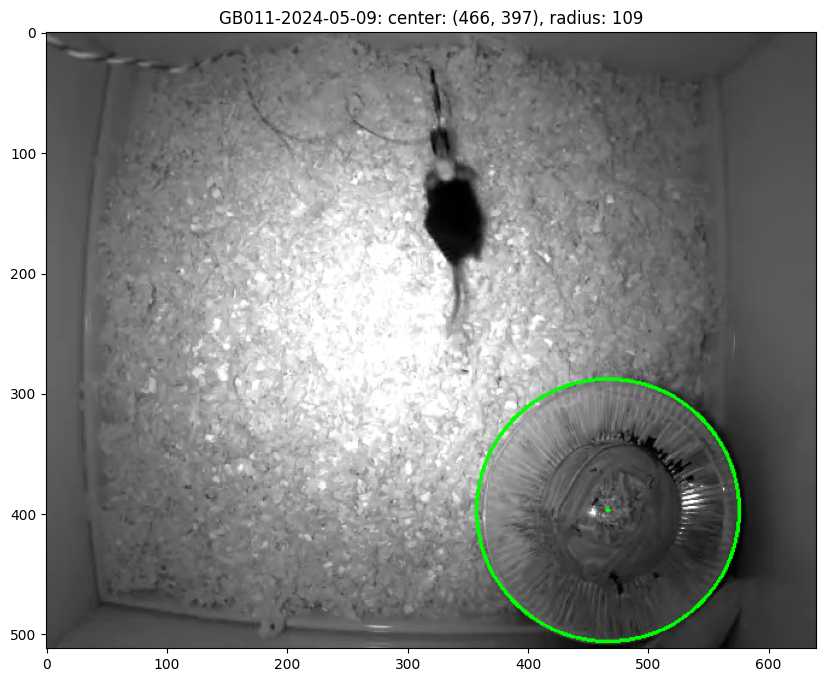

In [297]:
sesh = load_and_process_session(subject_id, date, target_freq=10)
analyze_single_session(sesh)

In [257]:
def split_data_for_decoding(session_data):
    # Ensure that the spike counts are normalized
    spike_counts = normalize_spike_counts(session_data.spike_counts)

    # Calculate the half point of the spike counts
    halfpoint = len(spike_counts[1]) // 2

    # Create masks for training and testing sets
    oa_mask = session_data.oa_pos[:halfpoint]
    wh_mask = session_data.wh_pos[:halfpoint]

    # Get training speed data
    oa_training_speed = session_data.oa_speed[:halfpoint][oa_mask]
    wh_training_speed = session_data.wh_speed[:halfpoint][wh_mask]

    # Get training spike counts
    oa_training_spike_counts = spike_counts[:, :halfpoint][:, oa_mask]
    wh_training_spike_counts = spike_counts[:, :halfpoint][:, wh_mask]

    # Create masks for testing sets
    oa_test_mask = session_data.oa_pos[halfpoint:]
    wh_test_mask = session_data.wh_pos[halfpoint:]

    # Get testing speed data
    oa_test_speed = session_data.oa_speed[halfpoint:][oa_test_mask]
    wh_test_speed = session_data.wh_speed[halfpoint:][wh_test_mask]

    # Get testing spike counts
    oa_testing_spike_counts = spike_counts[:, halfpoint:][:, oa_test_mask]
    wh_testing_spike_counts = spike_counts[:, halfpoint:][:, wh_test_mask]

    dca =  Bunch(
        oa_training_speed=oa_training_speed,
        wh_training_speed=wh_training_speed,
        oa_training_spike_counts=oa_training_spike_counts,
        wh_training_spike_counts=wh_training_spike_counts,
        oa_testing_speed=oa_test_speed,
        wh_testing_speed=wh_test_speed,
        oa_testing_spike_counts=oa_testing_spike_counts,
        wh_testing_spike_counts=wh_testing_spike_counts
    )

    return dca




In [258]:
from sklearn.linear_model import Ridge

def train_decoder(session_data):
    # Split the data into training and testing sets
    dca = split_data_for_decoding(session_data)
    
    # fit Ridge regression models for both contexts
    oa_model = Ridge(alpha=1)
    oa_model.fit(dca.oa_training_spike_counts.T, dca.oa_training_speed)


    wh_model = Ridge(alpha=1)
    wh_model.fit(dca.wh_training_spike_counts.T, dca.wh_training_speed)

    dca.oa_model = oa_model
    dca.wh_model = wh_model

    return dca
   

def test_decoder_within_context(dca):
    # Predict the speeds using the trained models
    
    oa1_pred_oa2 = dca.oa_model.predict(dca.oa_testing_spike_counts.T)
    wh1_pred_wh2 = dca.wh_model.predict(dca.wh_testing_spike_counts.T)

    
    oa1_pred_oa2_r2 = dca.oa_model.score(dca.oa_testing_spike_counts.T, dca.oa_testing_speed)
    wh1_pred_wh2_r2 = dca.wh_model.score(dca.wh_testing_spike_counts.T, dca.wh_testing_speed) 

    dca.oa1_pred_oa2 = oa1_pred_oa2
    dca.wh1_pred_wh2 = wh1_pred_wh2
    dca.oa1_pred_oa2_r2 = oa1_pred_oa2_r2
    dca.wh1_pred_wh2_r2 = wh1_pred_wh2_r2


In [259]:
def test_decoder_cross_context(dca):
    # Predict the speeds using the trained models
    oa1_pred_wh2 = dca.oa_model.predict(dca.wh_testing_spike_counts.T)
    wh1_pred_oa2 = dca.wh_model.predict(dca.oa_testing_spike_counts.T)

    
    oa1_pred_wh2_r2 = dca.oa_model.score(dca.wh_testing_spike_counts.T, dca.wh_testing_speed)
    wh1_pred_oa2_r2 = dca.wh_model.score(dca.oa_testing_spike_counts.T, dca.oa_testing_speed)

    dca.oa1_pred_wh2 = oa1_pred_wh2
    dca.wh1_pred_oa2 = wh1_pred_oa2
    dca.oa1_pred_wh2_r2 = oa1_pred_wh2_r2
    dca.wh1_pred_oa2_r2 = wh1_pred_oa2_r2



In [260]:
from scipy.stats import mannwhitneyu

def compare_within_cross_context_decoding(dca):
    # Calculate residuals for within context predictions
    oa_residuals = (dca.oa_testing_speed - dca.oa1_pred_oa2) ** 2
    wh_residuals = (dca.wh_testing_speed - dca.wh1_pred_wh2) ** 2

    # Calculate residuals for cross context predictions
    oa_on_wh_residuals = (dca.wh_testing_speed - dca.oa1_pred_wh2) ** 2
    wh_on_oa_residuals = (dca.oa_testing_speed - dca.wh1_pred_oa2) ** 2

    # Perform Mann-Whitney U test
    oa_vs_cross = mannwhitneyu(oa_residuals, wh_on_oa_residuals)
    wh_vs_cross = mannwhitneyu(wh_residuals, oa_on_wh_residuals)

    dca.oa_vs_cross = oa_vs_cross
    dca.wh_vs_cross = wh_vs_cross


In [261]:


def calculate_weight_vector_cosine_similarity(dca):
    # Extract the weights from the models
    w_oa = dca.oa_model.coef_
    w_wh = dca.wh_model.coef_

    # Calculate the dot product and cosine similarity
    dot_product = np.dot(w_oa, w_wh)
    cosine_similarity = dot_product / (np.linalg.norm(w_oa) * np.linalg.norm(w_oa))

    return cosine_similarity, dot_product



In [262]:

def plot_weights(dca):
    # Extract the weights from the models
    w_oa = dca.oa_model.coef_
    w_wh = dca.wh_model.coef_

    # Create a scatter plot of the weights
    plt.figure(figsize=(8, 6))
    plt.scatter(w_oa, w_wh, alpha=0.5)
    plt.xlabel('OA Weights')
    plt.ylabel('WH Weights')
    plt.title('Scatter plot of OA vs WH weights')
    plt.grid(True)
    plt.show()




In [ ]:
def generate_null_model()

In [263]:
def calculate_r2_leaveout(dca):

    w_oa = dca.oa_model.coef_
    w_wh = dca.wh_model.coef_

    w_oa_sort = np.argsort(w_oa)[::-1]
    w_wh_sort = np.argsort(w_wh)[::-1]

    oa_within_train_spks = dca.oa_training_spike_counts.T[:, w_oa_sort]
    wh_within_train_spks = dca.wh_training_spike_counts.T[:, w_wh_sort]
    oa_between_train_spks = dca.oa_training_spike_counts.T[:, w_wh_sort]
    wh_between_train_spks = dca.wh_training_spike_counts.T[:, w_oa_sort]

    oa_within_testing_spks = dca.oa_testing_spike_counts.T[:, w_oa_sort]
    wh_within_testing_spks = dca.wh_testing_spike_counts.T[:, w_wh_sort]
    oa_between_testing_spks = dca.oa_testing_spike_counts.T[:, w_wh_sort]
    wh_between_testing_spks = dca.wh_testing_spike_counts.T[:, w_oa_sort]

    n_iterations = len(w_oa_sort) - 1
    
    r2_oa_leaveout_oa = np.zeros(n_iterations)
    r2_wh_leaveout_wh = np.zeros(n_iterations)
    r2_oa_leaveout_wh = np.zeros(n_iterations)
    r2_wh_leaveout_oa = np.zeros(n_iterations)

    ridge = Ridge(alpha=1)

    for i in range(n_iterations):

        # train model leaving out highest weighted neurons

        # within context
        
        ridge.fit(oa_within_train_spks[:, i:], dca.oa_training_speed)
        r2_oa_leaveout_oa[i] = ridge.score(oa_within_testing_spks[:, i:], dca.oa_testing_speed)

        
        ridge.fit(wh_within_train_spks[:, i:], dca.wh_training_speed)
        r2_wh_leaveout_wh[i] = ridge.score(wh_within_testing_spks[:, i:], dca.wh_testing_speed)

        # between context
        
        ridge.fit(oa_between_train_spks[:, i:], dca.oa_training_speed)
        r2_oa_leaveout_wh[i] = ridge.score(oa_between_testing_spks[:, i:], dca.oa_testing_speed)

       
        ridge.fit(wh_between_train_spks[:, i:], dca.wh_training_speed)
        r2_wh_leaveout_oa[i] = ridge.score(wh_between_testing_spks[:, i:], dca.wh_testing_speed)

    dca.r2_oa_leaveout_oa = r2_oa_leaveout_oa
    dca.r2_wh_leaveout_wh = r2_wh_leaveout_wh
    dca.r2_oa_leaveout_wh = r2_oa_leaveout_wh
    dca.r2_wh_leaveout_oa = r2_wh_leaveout_oa

    








In [298]:
split_data_for_decoding(sesh)
dca = train_decoder(sesh)
test_decoder_within_context(dca)
test_decoder_cross_context(dca)


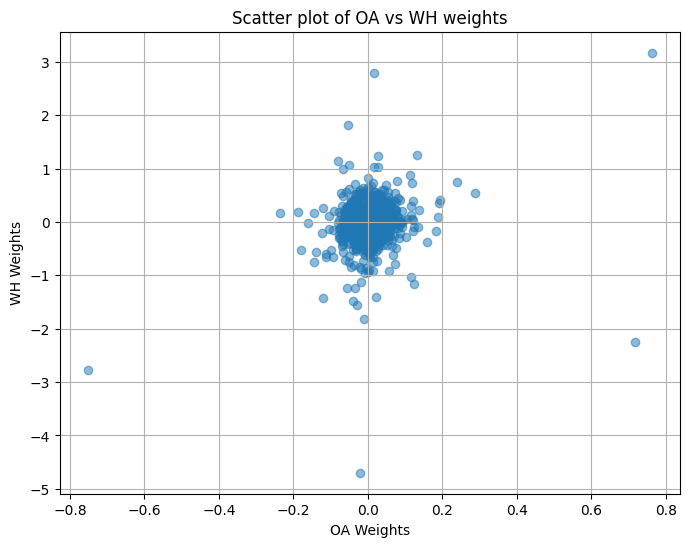

In [299]:
compare_within_cross_context_decoding(dca)
calculate_weight_vector_cosine_similarity(dca)
plot_weights(dca)
calculate_r2_leaveout(dca)

In [307]:

w_oa = dca.oa_model.coef_
w_wh = dca.wh_model.coef_

w_oa_sort = np.argsort(w_oa)[::-1]
w_wh_sort = np.argsort(w_wh)[::-1]


r_oa = sesh.r_oa
r_wh = sesh.r_wh

Text(0, 0.5, 'Correlation Open Arena')

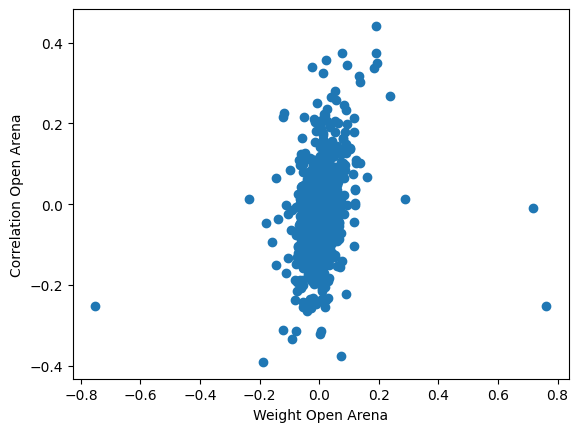

In [308]:
plt.scatter(w_oa, r_oa)
plt.xlabel("Weight Open Arena")
plt.ylabel("Correlation Open Arena")


Text(0, 0.5, 'Correlation Wheel')

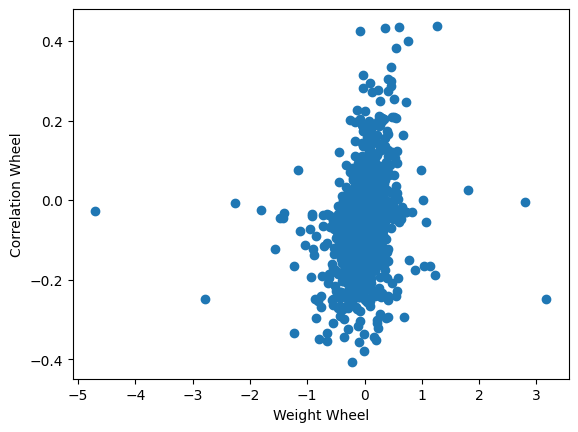

In [309]:
plt.scatter(w_wh, r_wh)
plt.xlabel("Weight Wheel")
plt.ylabel("Correlation Wheel")

Text(0, 0.5, 'Correlation Wheel')

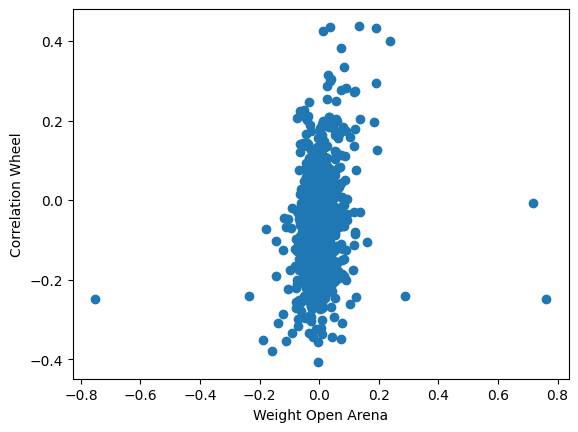

In [310]:
plt.scatter(w_oa, r_wh)
plt.xlabel("Weight Open Arena")
plt.ylabel("Correlation Wheel")

Text(0, 0.5, 'Correlation Open Arena')

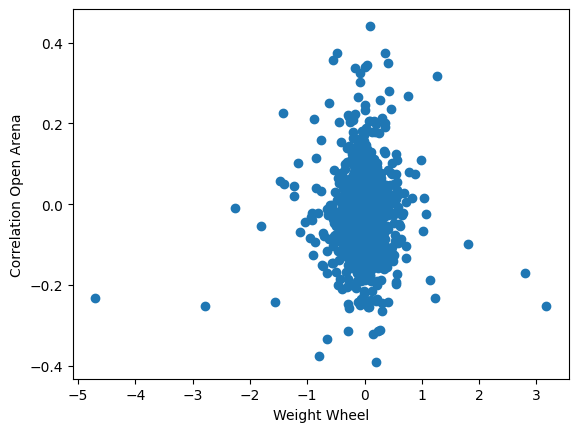

In [311]:
plt.scatter(w_wh, r_oa)
plt.xlabel("Weight Wheel")
plt.ylabel("Correlation Open Arena")

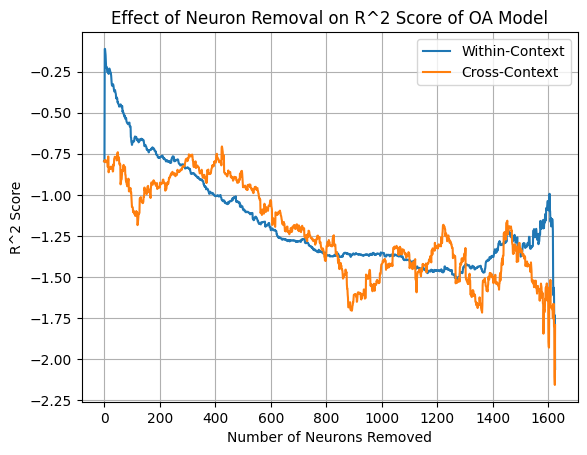

In [312]:
plt.plot(dca.r2_oa_leaveout_oa, label="Within-Context")
plt.plot(dca.r2_oa_leaveout_wh, label="Cross-Context")
plt.xlabel('Number of Neurons Removed')
plt.ylabel('R^2 Score')
plt.title('Effect of Neuron Removal on R^2 Score of OA Model')
plt.legend()
plt.grid()
plt.show()

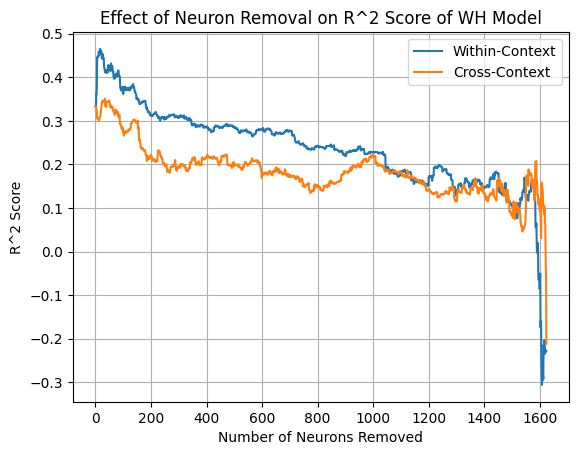

In [313]:
plt.plot(dca.r2_wh_leaveout_wh, label="Within-Context")
plt.plot(dca.r2_wh_leaveout_oa, label="Cross-Context")
plt.xlabel('Number of Neurons Removed')
plt.ylabel('R^2 Score')
plt.title('Effect of Neuron Removal on R^2 Score of WH Model')
plt.legend()
plt.grid()
plt.show()

In [ ]:
n_neurons = len(dec.spike_counts[0])
w_start =  1000
w_end = 5000
    
# Create figure
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 12), 
                                       gridspec_kw={'height_ratios': [1, 1, 1]},
                                       sharex=True)
    
# Plot velocities
ax1.plot(oa_test_speed[w_start:w_end], color='darkgreen', alpha=0.8)
ax1.set_xticklabels([])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_ylabel('Measured', color='black', fontsize=18, weight="bold")

ax2.plot(oa_predictions[w_start:w_end], color='green', alpha=0.8)
ax2.set_xticklabels([])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_ylabel('Trained Same Context', color='black', fontsize=18, weight='bold')

ax3.plot(wh_on_oa_predictions[w_start:w_end], color='green', alpha=0.8)
ax3.set_xticklabels([])
ax3.set_xticks([])
ax3.set_yticks([])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.set_ylabel('Trained Different Context', color='black', fontsize=18, weight='bold')

plt.tight_layout()
plt.show()